In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax

Using TensorFlow backend.


In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# # 1次元へ整形
# x_train, x_test = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [3]:
network = DeepConvNet()

# パラメータの保存
network.load_params("deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [4]:
true_idxs = [[], [], [], [], [], [], [], [], [], []]
for i, t in enumerate(x_test):
    pre_l = np.argmax(network.predict(t.reshape(1, 1, 28, 28)))
    true_l = t_test[i]
    if pre_l == true_l:
        true_idxs[true_l].append(i)

In [5]:
true_x_list = []
for i in range(10):
    true_nums = true_idxs[i][:10]
    true_x_list.append(list(map(lambda x: [x_test[x]], true_nums)))
    
true_x_list = np.array(true_x_list)
true_x_list.shape

(10, 10, 1, 28, 28)

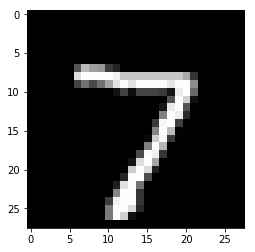

(28, 28)


In [6]:
x = x_test[0].copy()
plt.imshow(x, 'gray')
plt.show()
print(x.shape)

In [7]:
x = x.reshape(-1, 1, 28, 28)
pred = network.predict(x)
pred_probability = softmax(pred)
pred_probability

array([[4.09270345e-11, 4.14774472e-09, 6.66339952e-10, 2.53388230e-09,
        1.00733911e-09, 7.27067004e-11, 3.13935327e-12, 9.99999990e-01,
        2.84502728e-10, 1.17001944e-09]])

In [8]:
pred_label = np.argmax(pred, axis=1)
pred_label

array([7])

In [9]:
def generate_adv2(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x.reshape(1, 1, 28, 28), np.array([label]))
    d = d.reshape(28, 28)
#     plt.imshow(d, 'gray')
#     plt.show()
    p = eps * np.sign(d)
#     NNだと「-」でうまくいってたが、CNNだと「+」の方がうまく行く。最適化の違いのせい？
    adv = (x + p).clip(min=0, max=1)
#     plt.imshow(adv, 'gray')
#     plt.show()
    adv = adv.reshape(1, 1, 28, 28)
    return adv

In [10]:
adv_x = generate_adv2(x, 7, network, 0.5)
pred = network.predict(adv_x)
pred_probability = softmax(pred)[0]
print(max(pred_probability))
pred_label = np.argmax(pred, axis=1)
print(pred_label)

0.2651004584390568
[3]


In [11]:
def compare_eps(x, label, network, eps_list):
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = fig.add_subplot(5, 5, 1)
    ax.imshow(x, 'gray')
    pre = network.predict(x.reshape(1, 1, 28, 28))
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 4)
    ax.set_title(f"base, {pre_label} : {pre_score}")

    for i, eps in enumerate(eps_list):
        adv = generate_adv2(x.reshape(1, 1, 28, 28), label, network, eps)
        ax = fig.add_subplot(5, 5, i+2)
        ax.imshow(adv.reshape(28,28), 'gray')
        adv_pre = network.predict(adv)
        adv_label = np.argmax(adv_pre)
        adv_score = round(max(softmax(adv_pre[0])), 4)
        ax.set_title(f"eps[{eps}], {adv_label} : {adv_score}")

    plt.show()

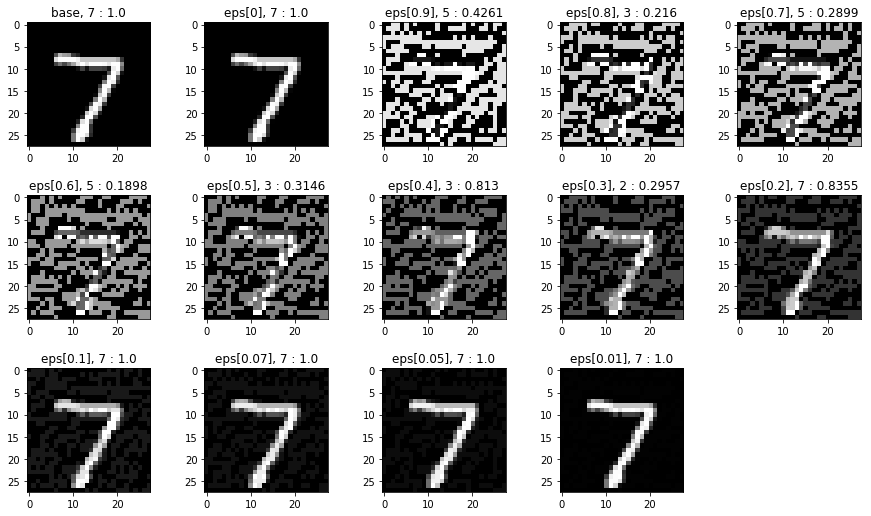

In [12]:
eps_list = [0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.07, 0.05, 0.01]
compare_eps(x.reshape(28, 28), 7, network, eps_list)

0


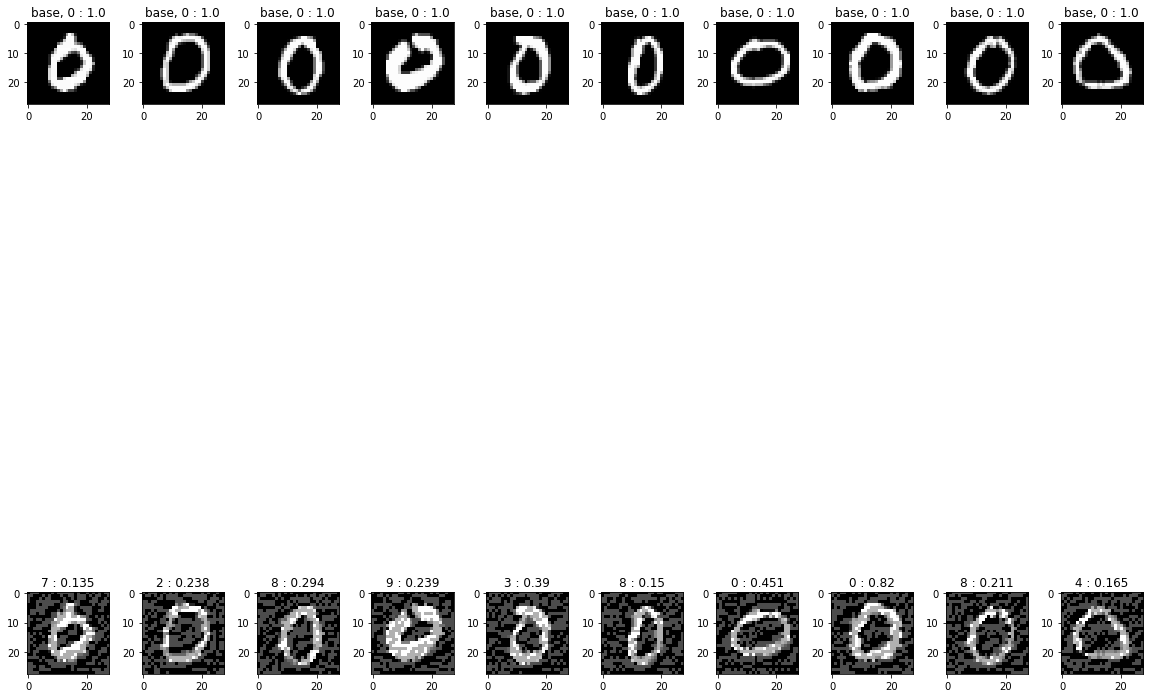

1


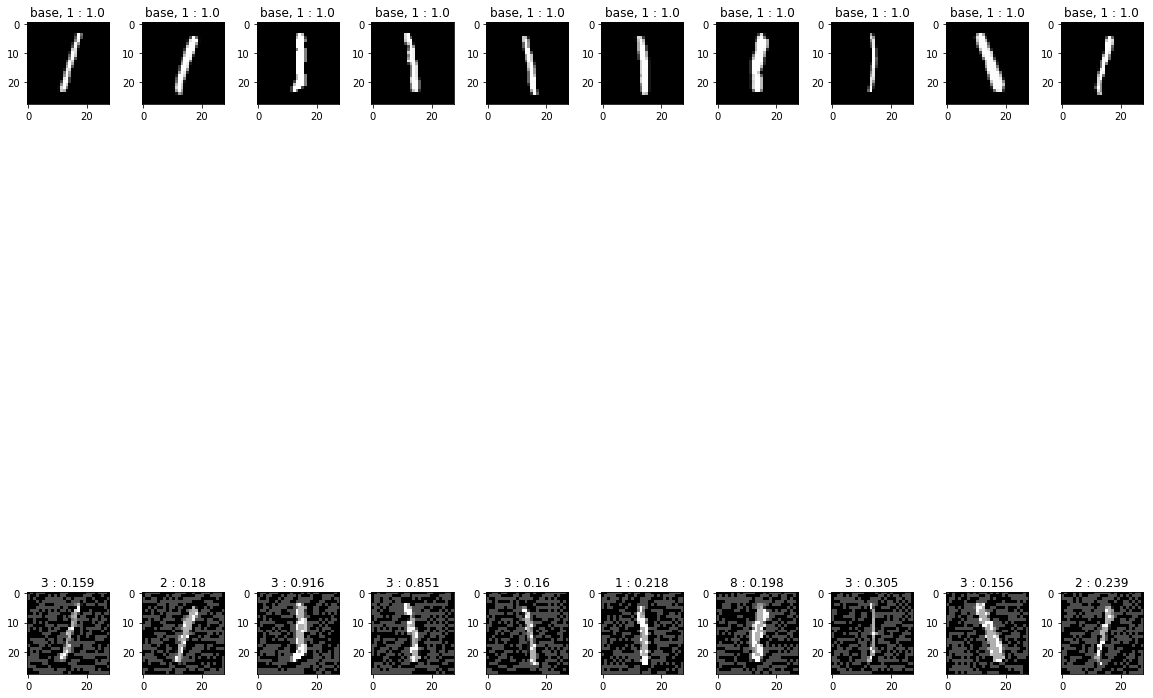

2


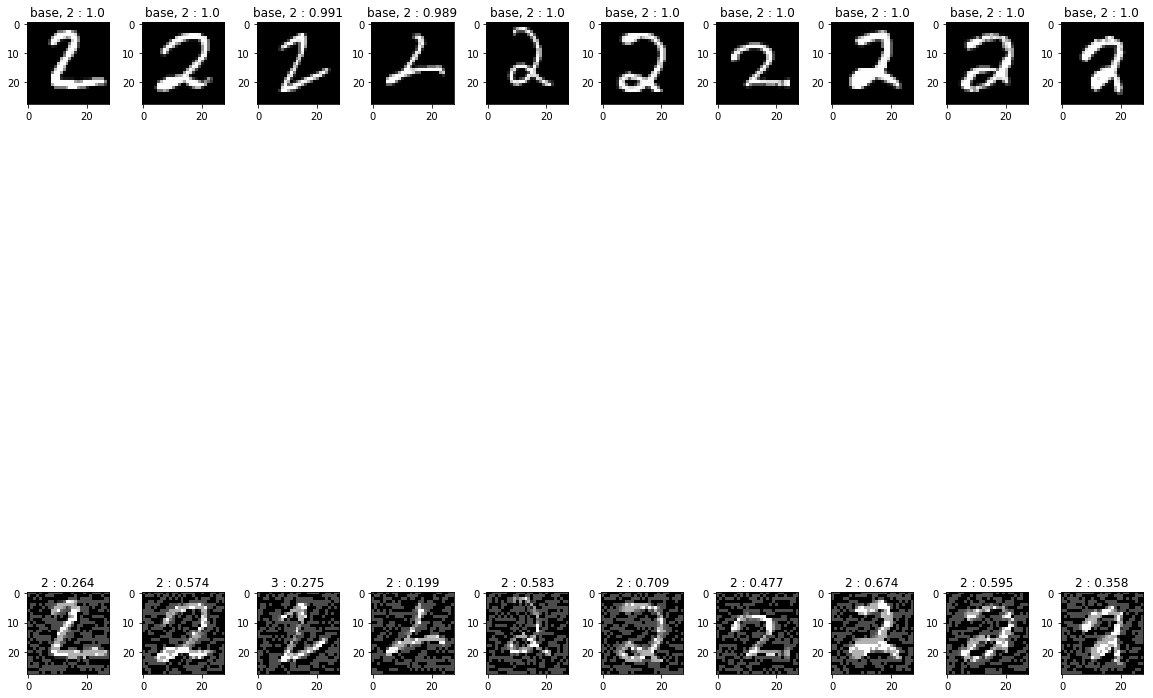

3


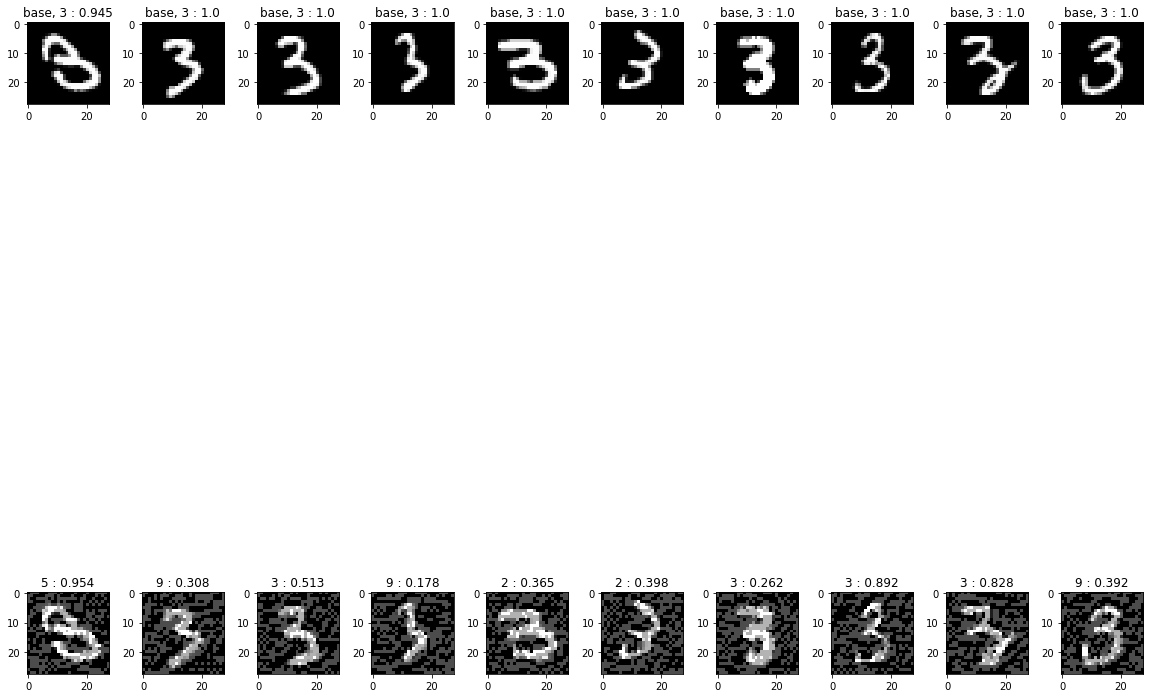

4


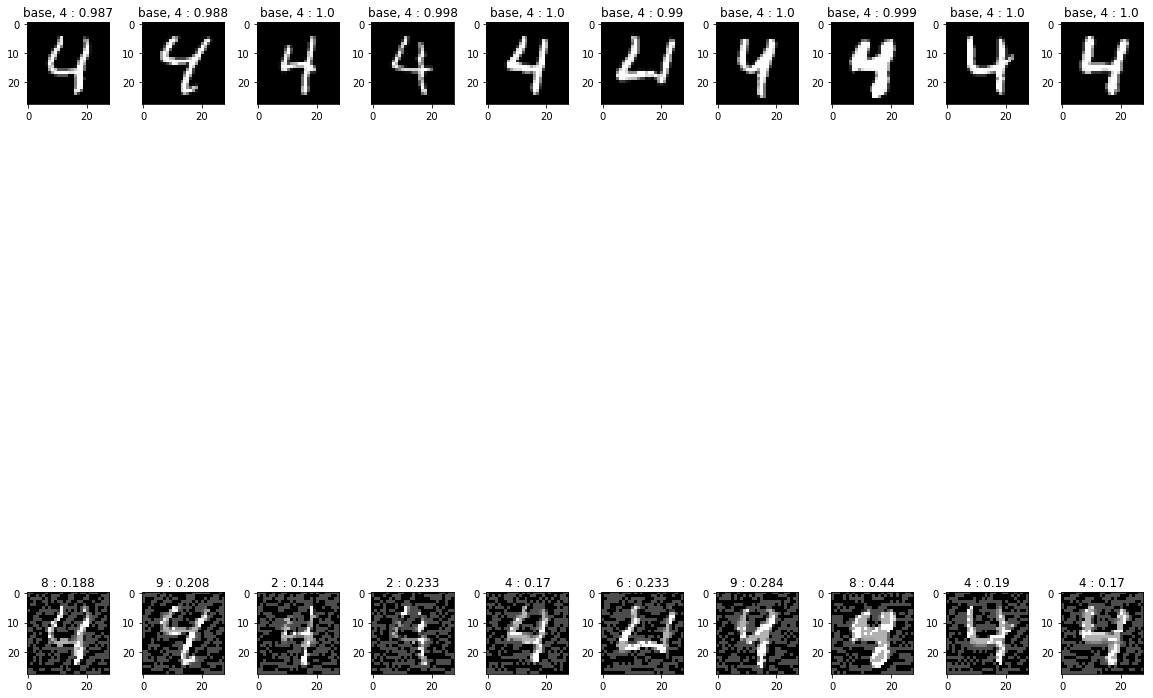

5


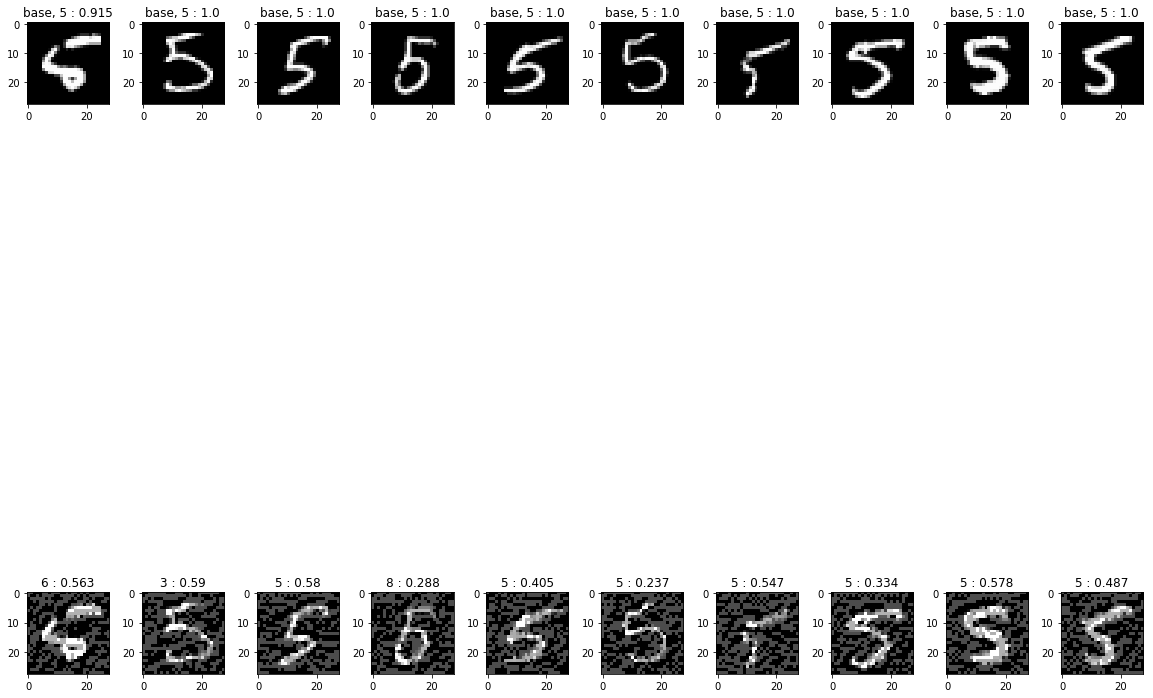

6


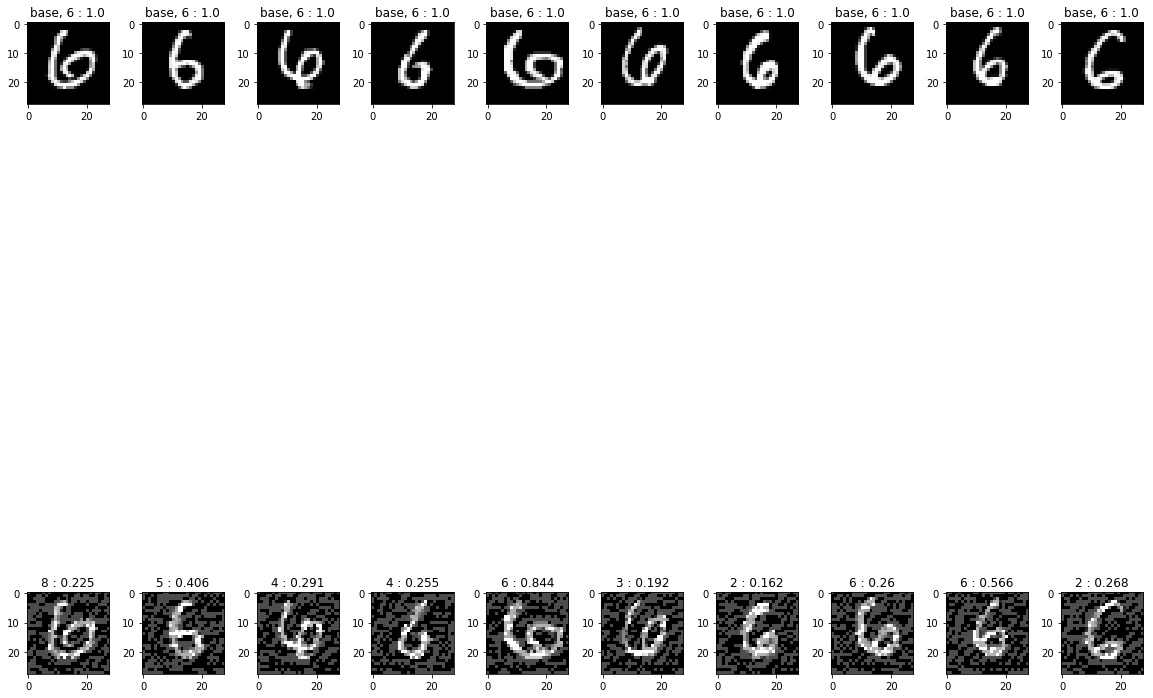

7


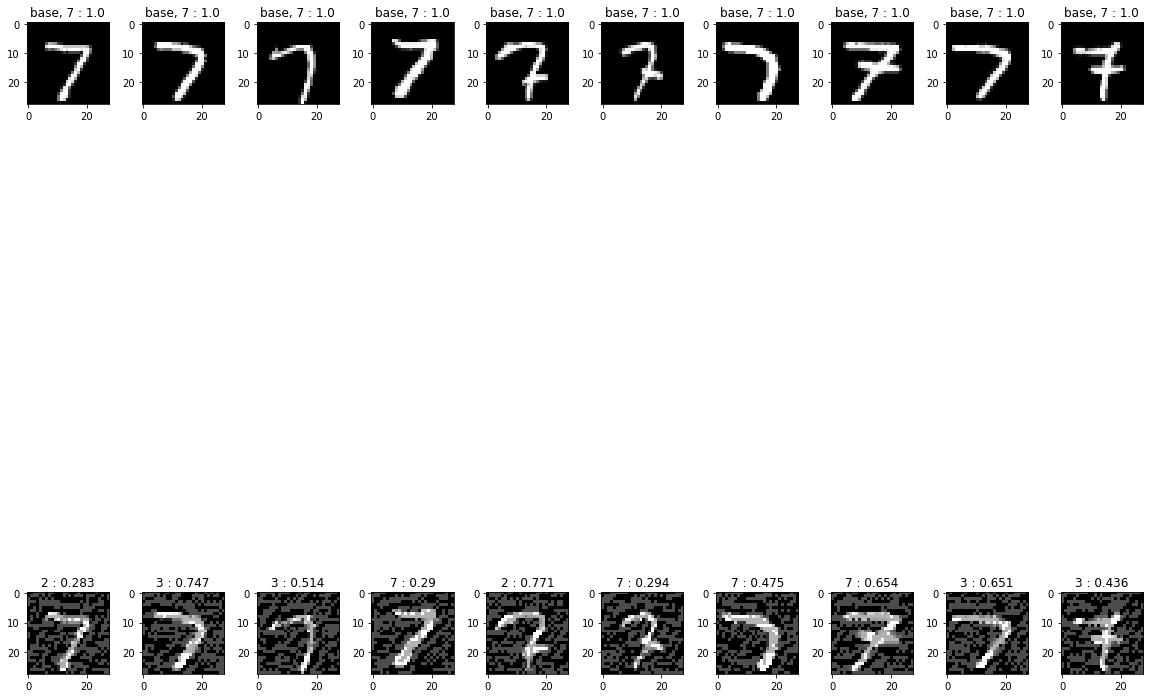

8


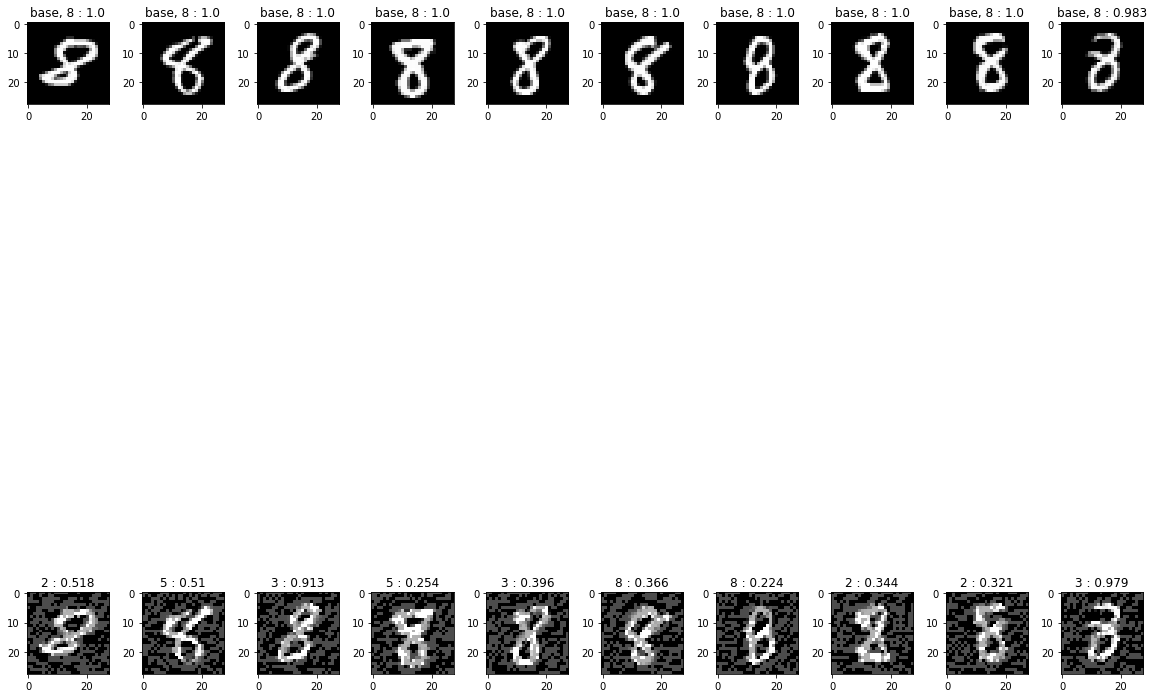

9


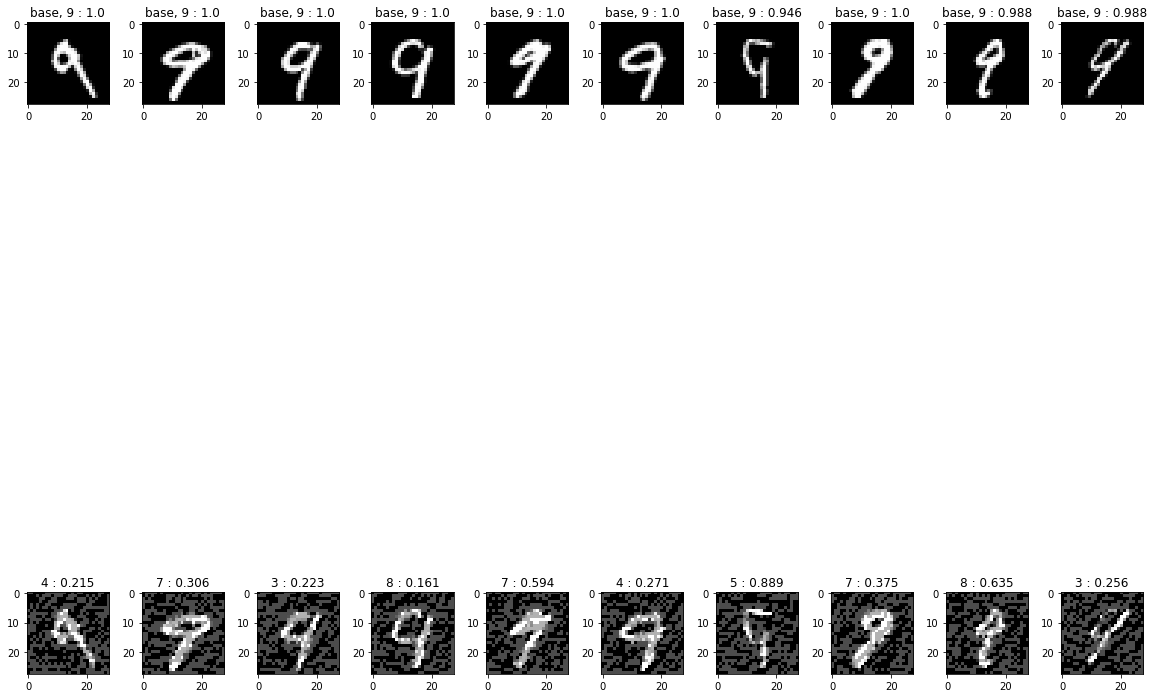

In [15]:
for i, nums in enumerate(true_x_list):
    print(i)
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)
    
    for j, x in enumerate(nums):
        x = x.reshape(1, 1, 28, 28)
        ax = fig.add_subplot(2, 10, j+1)
        ax.imshow(x.reshape(28,28), 'gray')
        pre = network.predict(x)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 3)
        ax.set_title(f"base, {pre_label} : {pre_score}")

        adv = generate_adv2(x, i, network, 0.3)
        ax = fig.add_subplot(2, 10, j+11)
        ax.imshow(adv.reshape(28,28), 'gray')
        pre = network.predict(adv)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 3)
        ax.set_title(f"{pre_label} : {pre_score}")

    plt.show()